In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

# Load Dataset

In [2]:
x_train = np.load('dataset/x_train.npy').astype(np.float32)
y_train = np.load('dataset/y_train.npy').astype(np.float32)
x_val = np.load('dataset/x_val.npy').astype(np.float32)
y_val = np.load('dataset/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(6281, 26, 34, 1) (6281, 1)
(698, 26, 34, 1) (698, 1)


# Preview

(26, 34)


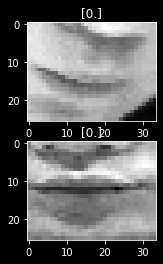

In [3]:
plt.subplot(2, 1, 1)
plt.title(str(y_train[0]))
plt.imshow(x_train[0].reshape((26, 34)), cmap='gray')
plt.subplot(2, 1, 2)
plt.title(str(y_val[3]))
plt.imshow(x_val[3].reshape((26, 34)), cmap='gray')
print(x_val[3].reshape((26, 34)).shape)

# Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

# Build Model

In [5]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 34, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 4, 128)         0     

# Train

In [6]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[ 
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/50
197/197 [==============================] - 5s 23ms/step - loss: 0.5334 - acc: 0.6943 - val_loss: 0.1128 - val_acc: 0.9470

Epoch 00001: val_acc improved from -inf to 0.94699, saving model to models\2021_02_23_00_30_24.h5
Epoch 2/50
197/197 [==============================] - 4s 19ms/step - loss: 0.1638 - acc: 0.9406 - val_loss: 0.0447 - val_acc: 0.9928

Epoch 00002: val_acc improved from 0.94699 to 0.99284, saving model to models\2021_02_23_00_30_24.h5
Epoch 3/50
197/197 [==============================] - 4s 19ms/step - loss: 0.0988 - acc: 0.9751 - val_loss: 0.0520 - val_acc: 0.9871

Epoch 00003: val_acc did not improve from 0.99284
Epoch 4/50
197/197 [==============================] - 4s 19ms/step - loss: 0.0738 - acc: 0.9794 - val_loss: 0.0224 - val_acc: 0.9871

Epoch 00004: val_acc did not improve from 0.99284
Epoch 5/50
197/197 [==============================] - 4s 19ms/step - loss: 0.0713 - acc: 0.9819 - val_loss: 0.0138 - val_acc: 0.9971

Epoch 00005: val_acc improved f

# Confusion Matrix

test acc: 1.0


<AxesSubplot:>

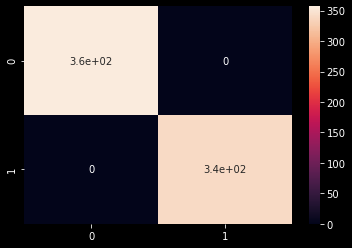

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.h5' % (start_time))
# model = load_model('models/2021_02_22_16_05_14.h5')

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

# Distribution of Prediction

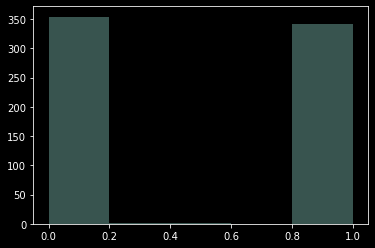

In [8]:
ax = sns.distplot(y_pred, kde=False)